
# RUN VCE - moved to separate script

# PLOT IMGS

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [ ]:
T = 300
gradscale=500
folder_to_save = f"simple_guidance_class_removing_maxnoised{T}_gradscale{gradscale}"
folder_to_save=f"/home/jk/Joint-Diffusion-in-Latent-Space/vce_results/{folder_to_save}"

cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]
for class_ in ["Cardiomegaly"]:
    x_samples =torch.load(f'{folder_to_save}/{class_}_x_samples.pt')
    pred_o = torch.load(f'{folder_to_save}/{class_}_pred_o.pt')
    img_original = torch.load(f'{folder_to_save}/{class_}_img_original.pt')
    pred_o_ext = torch.load(f'{folder_to_save}/{class_}_pred_o_ext.pt')
    pred_ext = torch.load(f'{folder_to_save}/{class_}_pred_ext.pt')
    bbox = torch.load(f'{folder_to_save}/{class_}_bbox.pt')
print(len(x_samples))

In [ ]:
idx_from_batch = 12
fig, axes = plt.subplots(1, 3, figsize=(20, 15))


# Plot the images on the subplots
denoised_guided_normalized = x_samples.cpu()[idx_from_batch].permute(1,2,0)
denoised_guided = denoised_guided_normalized*0.5+0.5
img_ref_normalized = img_original.cpu()[idx_from_batch].permute(1,2,0)
img_ref = img_ref_normalized*0.5+0.5
diff = abs(denoised_guided - img_ref)

ax = 0
axes[ax].imshow(denoised_guided, cmap='gray')
axes[ax].axis('off')
axes[ax].set_title("Denoised")

ax +=1
axes[ax].imshow(img_ref, cmap='gray')
axes[ax].axis('off')
axes[ax].set_title("Original")

ax +=1


x, y, w, h = bbox[idx_from_batch][0], bbox[idx_from_batch][1],bbox[idx_from_batch][2], bbox[idx_from_batch][3]
# Scale the bounding box coordinates from 1024x1024 to 256x256
scaled_x = x * 0.25
scaled_y = y * 0.25
scaled_w = w * 0.25
scaled_h = h * 0.25

# Create a rectangle patch using the scaled coordinates
rect = patches.Rectangle((scaled_x, scaled_y), scaled_w, scaled_h, linewidth=1, edgecolor='r', facecolor='none')

if "removing" in folder_to_save:
    # Add the rectangle patch to the plot
    axes[ax].add_patch(rect)


axes[ax].imshow(diff)
axes[ax].axis('off')
axes[ax].set_title("Abs diff")


#fig.suptitle(ret[3][0][idx_from_batch])
pred_o_for_item = torch.nn.functional.sigmoid(pred_o[idx_from_batch])
pred_o_ext_for_item = torch.nn.functional.sigmoid(pred_o_ext[idx_from_batch])
pred_ext_for_item = torch.nn.functional.sigmoid(pred_ext[idx_from_batch])
id_class = cl_list.index(class_)
print('all predictins for orig x', pred_o_ext_for_item)
print('all predictins for x pred start', pred_ext_for_item)
print(f'predicitons for x original JOINT, only class {cl_list[id_class]}', pred_o_for_item[id_class])
print(f'predicitons for x original EXT, only class {cl_list[id_class]}', pred_o_ext_for_item[id_class])
print(f'predicitons for x pred start EXT, only class {cl_list[id_class]}',pred_ext_for_item[id_class])



# TABLES

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
import torch
import torchvision.transforms as transforms
import pandas
import torch
from tqdm import tqdm

class DenseNet121(nn.Module):
    """Model modified.

    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.

    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x


/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# import torch

# # Load the full checkpoint
# checkpoint = torch.load("/home/jk/Joint-Diffusion-in-Latent-Space/logs/logs_vce_wacv/chexnet.pth.tar")

# # Extract the nested state_dict
# original_state_dict = checkpoint['state_dict']

# # Create a new state_dict with updated keys
# new_state_dict = {}
# for key, value in original_state_dict.items():
    
#     new_key = key.replace("module.densenet121","densenet121")

#     if "norm.weight" not in new_key and "norm.bias" not in new_key and "norm.running" not in new_key:
#         new_key = new_key.replace('norm.', 'norm')
    
#     if "conv.weight" not in new_key and "conv.bias" not in new_key:
#         new_key = new_key.replace("conv.","conv")
    
#     new_state_dict[new_key] = value
    

# # Update the checkpoint with the modified state_dict
# checkpoint['state_dict'] = new_state_dict

# # Save the updated checkpoint
# torch.save(checkpoint, '/home/jk/Joint-Diffusion-in-Latent-Space/logs/logs_vce_wacv/chexnet_updated.pth.tar')

# # Print a message indicating completion
# print("Updated state_dict keys and saved the new checkpoint.")


In [50]:
# initialize and load the model
torch.set_printoptions(precision=3, sci_mode=False)
N_CLASSES = 14
EXT_CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

CKPT_PATH = '/home/jk/Joint-Diffusion-in-Latent-Space/logs/logs_vce_wacv/chexnet_updated.pth.tar'

model_ext = DenseNet121(N_CLASSES).cuda()
checkpoint = torch.load(CKPT_PATH)
model_ext.load_state_dict(checkpoint['state_dict'])
model_ext.eval()


/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet121(
  (densenet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [4]:
# Define the transformations
normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

transformations = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    normalize
])

# Function to apply transformations to a tensor
def apply_transformations(tensor):
    transformed_tensors = []
    for img in tensor:
        # Convert grayscale to RGB by repeating the channel
        img_rgb = img.repeat(3, 1, 1).permute(1, 2, 0).numpy()
        img_rgb = (img_rgb*255).astype(np.uint8)
        
        # Apply transformations
        pil_img = transforms.ToPILImage()(img_rgb)
        transformed_tensor = transformations(pil_img)
        
        transformed_tensors.append(transformed_tensor)

    return torch.stack(transformed_tensors)


In [67]:
T = 200
gradscale=500
folder_to_save = f"simple_guidance_class_removing_maxnoised{T}_gradscale{gradscale}"
folder_to_save=f"/home/jk/Joint-Diffusion-in-Latent-Space/vce_results/{folder_to_save}"


min_prediction_confidence = 0.0
cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax"] #,"No Finding"]
#cl_list = ["Cardiomegaly"] #,"No Finding"]
indexes = []
data = []
data_one_class =[]
for cl_index, class_ in tqdm(enumerate(cl_list)):
    try:
        x_samples =torch.load(f'{folder_to_save}/{class_}_x_samples.pt')
        pred_o = torch.load(f'{folder_to_save}/{class_}_pred_o.pt')
        img_original = torch.load(f'{folder_to_save}/{class_}_img_original.pt')
        bbox = torch.load(f'{folder_to_save}/{class_}_bbox.pt')

        denoised_guided = x_samples*0.5+0.5
        img_ref = img_original*0.5+0.5

        # Apply transformations to both tensors
        transformed_denoised_guided = apply_transformations(denoised_guided).cuda()
        transformed_img_ref = apply_transformations(img_ref).cuda()

        output_ref = model_ext(transformed_img_ref).detach().cpu()
        output_guided = model_ext(transformed_denoised_guided).detach().cpu()

        id_external_model = EXT_CLASS_NAMES.index(class_)

        ref_pred=output_ref[:,id_external_model]
        guided_pred=output_guided[:,id_external_model]
        mask = ref_pred>=0.0 #min_prediction_confidence
        
        indexes.append(class_)

        # For guided vs reference samples we compute mean prediction increase / decrease for each class. 
        # We expect bigger changes (more decrease for removing and more increase for enforcing given class) for guided class than for the remaining classes
        diff_all = (output_guided[mask]-output_ref[mask]).mean(dim=0)
        diff_all_perc = ((output_guided[mask]-output_ref[mask])/output_ref[mask]).mean(dim=0)
        data.append(diff_all.detach().cpu())

        # Now, only for the guided class we compute 
        # mean prediction for original and guided sample
        # difference between mean predictions between reference and guided sample
        # precent difference between mean predictions between reference and guided sample
        diff_raw = (guided_pred-ref_pred).mean()
        diff_perc = (((guided_pred -ref_pred)/ref_pred).mean())*100
        n_samples = mask.sum()

        if id_external_model == 0:
            remaining_classes_pred_diff_perc = diff_all_perc[id_external_model + 1:] 
            remaining_classes_pred_diff = diff_all[id_external_model + 1:] 
        elif id_external_model == diff_all_perc.shape[0] - 1:
            remaining_classes_pred_diff_perc = diff_all_perc[:id_external_model]  
            remaining_classes_pred_diff = diff_all[:id_external_model] 
        else:
            remaining_classes_pred_diff_perc = torch.cat([diff_all_perc[:id_external_model], diff_all_perc[id_external_model + 1:]], dim=0)
            remaining_classes_pred_diff = torch.cat([diff_all[:id_external_model], diff_all[id_external_model + 1:]], dim=0)  

        remaining_classes_pred_diff_perc = abs(remaining_classes_pred_diff_perc).mean()*100
        remaining_classes_pred_diff = abs(remaining_classes_pred_diff).mean()

       
        data_one_class.append([ref_pred.mean(), guided_pred.mean(), diff_raw, diff_perc, n_samples, remaining_classes_pred_diff, remaining_classes_pred_diff_perc])

        del transformed_img_ref
        del transformed_denoised_guided
        del output_ref
        del output_guided
        del mask
        torch.cuda.empty_cache()
    except:
       pass



0it [00:00, ?it/s]

14it [00:35,  2.54s/it]


## Compare predictions across all classes - where do we see the biggest changes? Should be for guided class

In [68]:
print(f"Denoising timestep {T}, min_prediction_confidence {min_prediction_confidence}")
df=pandas.DataFrame(data, columns=EXT_CLASS_NAMES, index=indexes)
df= df.applymap(lambda x: x.item())
df.style.highlight_min(color = 'lightgreen', axis = 1) 


Denoising timestep 200, min_prediction_confidence 0.0


,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
Atelectasis,-0.353464,-0.022931,-0.264724,-0.058445,-0.038088,0.043851,-0.090610,-0.130540,-0.172075,0.016902,-0.102054,-0.003145,-0.091983,-0.096827
Cardiomegaly,0.018994,-0.385355,-0.098848,-0.047353,0.166252,0.046468,-0.045892,0.159498,0.021173,-0.104271,0.090673,0.052022,0.054559,0.070920
Effusion,-0.202340,-0.117680,-0.608862,-0.093797,-0.073827,0.075848,-0.085918,-0.069331,-0.229041,-0.112620,-0.011203,0.065501,-0.221444,0.069097
Mass,-0.009955,0.048994,-0.049213,-0.014821,-0.403184,-0.244259,0.018867,-0.097547,-0.116552,0.011964,-0.070135,-0.037141,-0.127494,-0.111209
Nodule,0.048716,0.004768,-0.011311,-0.002207,-0.292166,-0.372815,-0.008549,-0.068003,-0.075258,-0.030447,-0.069268,-0.031844,-0.074990,-0.002724
Pneumonia,0.035499,-0.005879,-0.015275,-0.077673,0.019436,-0.033686,-0.084818,0.052080,-0.054624,-0.095881,0.032980,-0.004474,0.009532,0.062136
Pneumothorax,0.022289,0.095369,-0.038435,0.041589,0.010223,-0.013293,0.088019,-0.200692,0.035137,0.045066,-0.250652,0.045203,-0.049930,0.061704


## Compare predictions only for denoised class

In [72]:
print(f"Denoising timestep {T}, min_prediction_confidence {min_prediction_confidence}")
df=pandas.DataFrame(data_one_class, columns=["mean_orig_pred", "mean_denoised_pred","abs diff", \
    "perc diff", "n_samples", "remaining_classes_pred_changes", "remaining_classes_pred_changes_perc"], index=indexes)
df= df.applymap(lambda x: x.item())
df.drop(columns=[ "n_samples","remaining_classes_pred_changes_perc"]) #not really informative

Denoising timestep 200, min_prediction_confidence 0.0


,mean_orig_pred,mean_denoised_pred,abs diff,perc diff,remaining_classes_pred_changes
Atelectasis,0.697064,0.343600,-0.353464,-46.596928,0.087091
Cardiomegaly,0.819561,0.434206,-0.385355,-46.732330,0.075148
Effusion,0.774826,0.165964,-0.608862,-77.916267,0.109819
Mass,0.752719,0.349535,-0.403184,-47.284195,0.073704
Nodule,0.704005,0.331190,-0.372815,-49.866928,0.055404
Pneumonia,0.624317,0.539499,-0.084818,-7.435013,0.038397
Pneumothorax,0.812789,0.612097,-0.200692,-21.243736,0.061301


In [60]:
print(df.to_latex(index=True, formatters={"name": str.upper},float_format="{:.3f}".format))

\begin{tabular}{lrrrrrrr}
\toprule
 & mean_orig_pred & mean_denoised_pred & abs diff & perc diff & n_samples & remaining_classes_pred_changes & remaining_classes_pred_changes_perc \\
\midrule
Atelectasis & 0.697 & 0.178 & -0.520 & -71.966 & 180 & 0.151 & 36.208 \\
Cardiomegaly & 0.820 & 0.264 & -0.556 & -67.884 & 146 & 0.091 & 132.341 \\
Effusion & 0.775 & 0.086 & -0.689 & -87.842 & 153 & 0.150 & 70.903 \\
Infiltration & 0.663 & 0.248 & -0.415 & -60.587 & 123 & 0.178 & 145.649 \\
Mass & 0.753 & 0.201 & -0.551 & -69.048 & 85 & 0.115 & 34.206 \\
Nodule & 0.704 & 0.224 & -0.480 & -64.158 & 79 & 0.092 & 28.792 \\
Pneumonia & 0.624 & 0.427 & -0.198 & -25.008 & 120 & 0.068 & 49.658 \\
Pneumothorax & 0.813 & 0.385 & -0.428 & -51.611 & 98 & 0.096 & 47.155 \\
\bottomrule
\end{tabular}



## Box ploty dla bboxow

100%|██████████| 1/1 [00:00<00:00, 15.46it/s]


136 155 56 77


100%|██████████| 1/1 [00:00<00:00, 21.55it/s]


114 189 69 204


100%|██████████| 1/1 [00:00<00:00, 20.53it/s]


173 185 47 58


  0%|          | 0/1 [00:00<?, ?it/s]

133 149 59 77


100%|██████████| 1/1 [00:00<00:00, 21.69it/s]

69 106 166 196



100%|██████████| 1/1 [00:00<00:00, 22.45it/s]

143 184 143 200



100%|██████████| 1/1 [00:00<00:00, 21.99it/s]

29 53 142 205


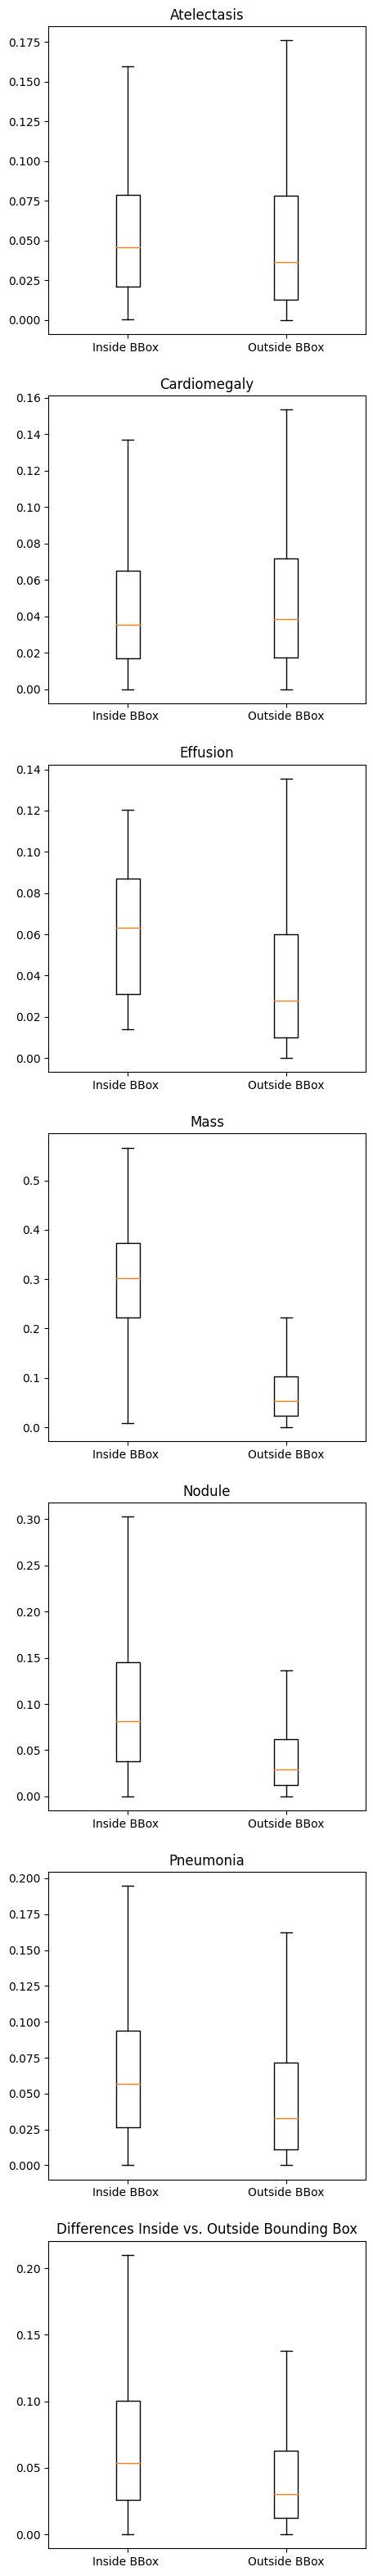

In [66]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm


T = 200
gradscale = 1000
folder_to_save = f"simple_guidance_class_removing_maxnoised{T}_gradscale{gradscale}"
folder_to_save = f"/home/jk/Joint-Diffusion-in-Latent-Space/vce_results/{folder_to_save}"

cl_list = ["Atelectasis","Cardiomegaly","Effusion", "Mass", "Nodule","Pneumonia","Pneumothorax"] 
fig, axes = plt.subplots(len(cl_list),1, figsize=(5, 40))

for idx, class_ in enumerate(cl_list):

    img_original = torch.load(f'{folder_to_save}/{class_}_img_original.pt')
    x_samples = torch.load(f'{folder_to_save}/{class_}_x_samples.pt')
    bboxes = torch.load(f'{folder_to_save}/{class_}_bbox.pt')

    # Initialize lists to store differences
    inside_diffs = []
    outside_diffs = []

    # Iterate through each image in the dataset
    for idx_from_batch in tqdm(range(len(img_original))[:1]):
        # Extract the bounding box for the selected image. Originally they were for 1024
        x, y, w, h = bboxes[idx_from_batch][0], bboxes[idx_from_batch][1], bboxes[idx_from_batch][2], bboxes[idx_from_batch][3]
        scaled_x = int(x * 0.25)
        scaled_y = int(y * 0.25)
        scaled_w = int(w * 0.25)
        scaled_h = int(h * 0.25)

        # Compute the pixel-wise differences between the original and transformed images
        diff = (img_original[idx_from_batch] - x_samples[idx_from_batch]).abs().mean(dim=0)
        # _, diff = ssim(img_ref.squeeze().numpy(), denoised_guided.squeeze().numpy(), data_range=1, full=True)
        # diff = torch.tensor(diff)

        # Create masks for inside and outside the bounding box
        mask = torch.zeros_like(diff, dtype=torch.bool)
        mask[scaled_y:(scaled_y + scaled_h), scaled_x:(scaled_x + scaled_w)] = True

        print(scaled_y, scaled_y + scaled_h, scaled_x, scaled_x + scaled_w)
        # Collect differences
        inside_diffs.extend(diff[mask].cpu().numpy())
        outside_diffs.extend(diff[~mask].cpu().numpy())

    # Convert lists to numpy arrays for plotting
    inside_diffs = np.array(inside_diffs)
    outside_diffs = np.array(outside_diffs)

    # Create box plots
    axes[idx].boxplot([inside_diffs, outside_diffs], labels=['Inside BBox ', 'Outside BBox'], showfliers=False)
    axes[idx].set_title(class_)
    plt.title(f'Differences Inside vs. Outside Bounding Box')
plt.show()
